In [103]:
import cv2
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import csv
import matplotlib.pyplot as plt
import itertools
import random

In [104]:
num_labels = 6
# random.seed(0)

In [105]:
def load_frames(vid_path):
    frames = []
    
    imgs = os.listdir(vid_path)
    for i in range(len(imgs)):
        img_path = os.path.join(vid_path, imgs[i])
        frame = cv2.imread(img_path)

        frames.append(frame)

    return frames


def extract_optical_flow(frames):
    features = []

    # 初始化前一帧
    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

    for frame in frames[1:]:
        # 將當前帧轉換為灰度圖
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 計算光流
        flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # 將光流的水平和垂直分量組合為特徵向量
        flow_feature = flow.reshape(-1)
        features.append(flow_feature)

        # 更新前一帧
        prev_frame = gray

    return np.array(features)


def preprocess(path, csv_path):
    vids = [[] for _ in range(num_labels)]
    with open(csv_path, 'r') as file:
        rows = csv.reader(file)
        for row in rows:
            vids[int(row[2])].append(os.path.join(row[1], row[0]))
            
    features = []
    labels = []

    for l in range(num_labels):

        for i in range(len(vids[l])):
            vid_path = os.path.join(path, vids[l][i])
            frames = load_frames(vid_path)
            optical_flow_features = extract_optical_flow(frames)
            # print(optical_flow_features.shape)
            features.append(optical_flow_features)
            labels.append(l)    

    return np.array(features), np.array(labels)

In [106]:
X_train, y_train = preprocess('./dataset_aug', './train_4.csv')
print(X_train.shape, y_train.shape)
X_test, y_test = preprocess('./dataset_aug', './val_4.csv')
print(X_test.shape, y_test.shape)

(960, 29, 28800) (960,)
(240, 29, 28800) (240,)


In [107]:
"""
# 將三維特徵數組轉換為二維
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# 创建 SVM 模型
svm_model = SVC()

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train_flat, y_train)

# 打印最佳参数和最佳分数
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
"""

'\n# 將三維特徵數組轉換為二維\nX_train_flat = X_train.reshape((X_train.shape[0], -1))\nX_test_flat = X_test.reshape((X_test.shape[0], -1))\n\nparam_grid = {\'C\': [0.1, 1, 10, 100], \'kernel\': [\'linear\', \'rbf\', \'poly\', \'sigmoid\']}\n\n# 创建 SVM 模型\nsvm_model = SVC()\n\n# 使用 GridSearchCV 进行参数搜索\ngrid_search = GridSearchCV(svm_model, param_grid, cv=5)\ngrid_search.fit(X_train_flat, y_train)\n\n# 打印最佳参数和最佳分数\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)\n'

In [108]:
# 將三維特徵數組轉換為二維
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

svm_model = SVC(kernel='linear', C=0.1)

# 訓練SVM模型
svm_model.fit(X_train_flat, y_train)

# 在測試集上進行預測
y_pred = svm_model.predict(X_test_flat)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9125


In [109]:
cnf_matrix_sklearn = confusion_matrix(y_test, y_pred)
print(cnf_matrix_sklearn)

[[37  0  2  0  1  0]
 [ 1 35  1  1  2  0]
 [ 0  1 39  0  0  0]
 [ 0  1  0 37  2  0]
 [ 1  2  0  1 36  0]
 [ 0  0  4  0  1 35]]


In [110]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[37  0  2  0  1  0]
 [ 1 35  1  1  2  0]
 [ 0  1 39  0  0  0]
 [ 0  1  0 37  2  0]
 [ 1  2  0  1 36  0]
 [ 0  0  4  0  1 35]]


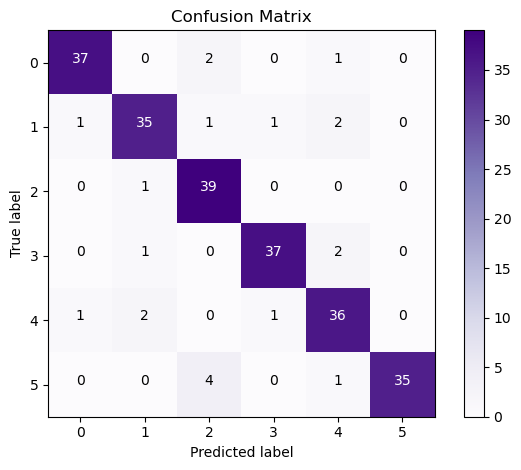

In [111]:
plot_confusion_matrix(cnf_matrix_sklearn, [0, 1, 2, 3, 4, 5], normalize=False, title='Confusion Matrix', cmap=plt.cm.Purples)

In [114]:
score1 = [0.5208, 0.5435, 0.5652, 0.4667, 0.4419]
print("ori: ", np.mean(score1))

score2 = [0.8292, 0.8208, 0.8416, 0.8125, 0.7625]
print("aug: ", np.mean(score2))

print("---")

score3 = [0.54, 0.5532, 0.5532, 0.4565, 0.4318]
print("ori: ", np.mean(score3))

score4 = [0.9416, 0.9042, 0.8875, 0.85, 0.9125]
print("aug: ", np.mean(score4))

ori:  0.50762
aug:  0.81332
---
ori:  0.50694
aug:  0.89916
